<a href="https://colab.research.google.com/github/wwoskie/Biostat_BI_2022/blob/HW_on_lecture_5/HW_on_lecture_5/homework_lecture_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Пришло время нашей первой домашней работы не на степике. Надеюсь, будет весело :)

Так как, `pandas` вы еще не проходили, то я вам немного помогу. Эту домашку можно делать как в питоне, так и в R, само задание будет написано в `Google Colaboratory`.

In [ ]:
# Pandas понадобится нам для чтения денных
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# В переменную data_path надо положить путь до данных
data_path = "data"
expression_data = pd.read_csv(f"{data_path}/homework_lecture_5_data.csv", index_col=0)
expression_data.head()

In [ ]:
b_cells_expression_data = expression_data.query("Cell_type == 'B_cell'")
nk_cells_expression_data = expression_data.query("Cell_type == 'NK_cell'")

В этом задании мы будем работать с данными об экспрессии генов в друх клеточных типах: в B-клетках и в NK-клетках. Выясним, средняя экспрессия каких генов значимо различается в этих клеточных типах.

Я буду показывать примеры на одном гене, а на основе них вы сможете сделать похожие задачи для всех генов.

In [ ]:
example_gene = "TMCC1"

## Задание 1

**2 баллов**

Посмотрим на распределение экспрессий гена `TMCC1` в обоих клеточных типах.

In [ ]:
sns.histplot(b_cells_expression_data[example_gene], stat="density");

In [ ]:
sns.histplot(nk_cells_expression_data[example_gene], stat="density");

Кажется, что они немного различаются. Для начала давайте попробуем еще раз проверить центральную предельную теорему.

**Задание:**

Напишите функцию, которая будет принимать на вход экспрессии гена, семплировать их них выборки размера `sample_size`, считать среднюю экспрессию и повторять это `n_samples` раз. Примените эту функцию к экспрессиям гена `TMCC1` в обоих клеточных типах, визуализируйте их. Отличаются ли средние экспрессии данного гена у этих клеточных типов?
 
Сигнатура функции:

```python
def demonstrate_clt(expressions, sample_size, n_samples):
    mean_expressions = []

    return mean_expressions
```

In [ ]:
def demonstrate_clt(expressions, sample_size, n_samples):
    mean_expressions = [np.mean(np.random.choice(expressions, size=sample_size)) for _ in range(n_samples)]
    return mean_expressions

In [ ]:
np.random.seed(42)
b_cells_sampled_mean_expr = demonstrate_clt(b_cells_expression_data[example_gene], 500, 5000)
nk_cells_sampled_mean_expr = demonstrate_clt(nk_cells_expression_data[example_gene], 500, 5000)

In [ ]:
sns.histplot(b_cells_sampled_mean_expr, color="skyblue", stat="density", label="B cells", kde=True)
sns.histplot(nk_cells_sampled_mean_expr, color="red", stat="density", label="NK cells", kde=True)
plt.legend();

А теперь посчитайте 95% доверительные интервалы для обоих распределений (примем тот факт, что средние распределены нормально для обоих клеточных типов) и скажите, отличается ли средняя экспрессия данного гена между клеточными типами?

In [ ]:
def ci_maker(population, sample_size, samples_mean):
    std = np.std(population)
    se = std / np.sqrt(sample_size)

    mean_mean = np.mean(samples_mean)
    left_b = mean_mean - 1.96 * se
    right_b = mean_mean + 1.96 * se

    return left_b, right_b

In [ ]:
# B cells CI
b_cells_left_b, b_cells_right_b = ci_maker(b_cells_expression_data[example_gene], 500, np.mean(b_cells_sampled_mean_expr))
b_cells_left_b, b_cells_right_b

In [ ]:
# NK cells CI
nk_cells_left_b, nk_cells_right_b = ci_maker(nk_cells_expression_data[example_gene], 500, np.mean(nk_cells_sampled_mean_expr))
nk_cells_left_b, nk_cells_right_b

Получается, что средняя экспрессия не отличается, т.к. доверительные интервалы пересекаются 😯

## Задание 2

**4 баллов**

Вспомнили центральную предельную теорему и то, как считать доверительные интервалы в простом случае, теперь давайте воспользуемся библиотечной реализацией для того, чтобы протестировать уже все гены. 

In [ ]:
import scipy.stats as st

Посчитаем доверительные интервалы для нашего демонстрационного гена в обоих клеточных типах:

In [ ]:
# B клетки
st.t.interval(alpha=0.95, # 95% доверительный интервал
              df=len(b_cells_expression_data[example_gene]) - 1, # число степеней свободы - 1
              loc=np.mean(b_cells_expression_data[example_gene]), # Среднее
              scale=st.sem(b_cells_expression_data[example_gene])) # Стандартная ошибка среднего

In [ ]:
# NK клетки
st.t.interval(alpha=0.95, # 95% доверительный интервал
              df=len(nk_cells_expression_data[example_gene]) - 1, # число степеней свободы - 1
              loc=np.mean(nk_cells_expression_data[example_gene]), # Среднее
              scale=st.sem(nk_cells_expression_data[example_gene])) # Стандартная ошибка среднего

Напишите функцию для проверки того, что доверительные интервалы пересекаются. На лекции мы тестировали гипотезы для равенства среднего выборки заданному числу и проверяли, попало ли оно в границы этого интервала или нет, если оно оказывалось за ними, то мы говорили, что средние отличаются. Здесь же мы имеем дело с двумя выборками, поэтому будем проверять, пересекаются ли доверительные интервалы, и, если нет, то говорить о том, что средние в выборках отличаются.

```python
def check_intervals_intersect(first_ci, second_ci):   

    return are_intersect # True or False
```

In [ ]:
def check_intervals_intersect(first_ci, second_ci):
    if min(second_ci) < min(first_ci):
        second_ci, first_ci = first_ci, second_ci
    are_intersect = min(second_ci) < max(first_ci)
    return are_intersect # True or False

Теперь для каждого гена посчитайте доверительные интервалы в обоих клеточных типах, и проверьте, пересекаются ли они? Результаты можно добавлять в список, например:

```python
ci_test_results = [True, False, ..., True]
```

Попытайтесь оформить это в виде функции, которая будет принимать на вход две таблицы с экспрессиями и выдавать для каждого гена, значимо ли отличается его средняя экспрессия между клеточными типами.

```python
def check_dge_with_ci(first_table, second_table):
    # dge - differential gene expression

    return ci_test_results
```

In [ ]:
def check_dge_with_ci(first_table, second_table):
    # dge - differential gene expression
    ci_test_results = []

    for gene in first_table.select_dtypes('number').columns:
        first_ci = st.t.interval(alpha=0.95, # 95% доверительный интервал
              df=len(first_table[gene]) - 1, # число степеней свободы - 1
              loc=np.mean(first_table[gene]), # Среднее
              scale=st.sem(first_table[gene])) # Стандартная ошибка среднего

        second_ci = st.t.interval(alpha=0.95, # 95% доверительный интервал
              df=len(second_table[gene]) - 1, # число степеней свободы - 1
              loc=np.mean(second_table[gene]), # Среднее
              scale=st.sem(second_table[gene])) # Стандартная ошибка среднего

        ci_test_results.append(check_intervals_intersect(first_ci, second_ci))

    return ci_test_results

## Задание 3

**4 баллов**

Давайте теперь применим для той же задачи `z-критерий`. Будем считать, что в данном случае $\alpha$ = 0.05, и если полученное `p-value` будет меньше, то экспрессия генов значимо отличается.

In [ ]:
from statsmodels.stats.weightstats import ztest

In [ ]:
# Наш излюбленный ген
ztest(
    b_cells_expression_data[example_gene],
    nk_cells_expression_data[example_gene]
)

Попытайтесь оформить это в виде функции, которая будет принимать на вход две таблицы с экспрессиями и выдавать для каждого гена, значимо ли отличается его средняя экспрессия между клеточными типами.

```python
def check_dge_with_ztest(first_table, second_table):
    # dge - differential gene expression

    return z_test_results
```

In [ ]:
def check_dge_with_ztest(first_table, second_table):
    # я не знаю ок ли писать генератор тут, но написал
    z_test_results = [ztest(first_table[gene], second_table[gene])[1] < 0.05 for gene in first_table.select_dtypes('number').columns] 
    return z_test_results

## Задание 4

**10 баллов**

Теперь пришла пора оформить все ваши старания в виде программы. Напишите программу, которая принимает на вход следующие аргуметры:

1. `first_cell_type_expressions_path` &ndash; путь до таблицы с экспрессиями генов для одного клеточного типа;
2. `second_cell_type_expressions_path` &ndash; путь до таблицы с экспрессиями генов для второго клеточного типа;
3. `save_results_table` &ndash; название таблицы с результатами.

Считывать аргументы можно любым удобным способом (например, `input`, `argparse`).

Как читать данные при помощи пандаса мы уже знаем, осталось понять, как записывать результаты. Допустим, вы записывали результаты ваших тестов в списки, тогда создать пандасовский датафрейм можно следующим образом:

In [ ]:
# сначала немного перепишу функцию check_dge_with_ztest, чтобы возвращать сразу все что нужно

def check_dge_with_ztest(first_table, second_table):
    z_test_p_values = [round(ztest(first_table[gene], second_table[gene])[1], 4) for gene in first_table.select_dtypes('number').columns]
    z_test_results = np.array(z_test_p_values) < 0.05
    return z_test_p_values, z_test_results

In [ ]:
# и напишу функцию для вычисления средней экспрессии (не знаю, стоит ли так дробить)

def mean_diff_counter(first_table, second_table):
    mean_diff = [round(np.mean(first_table[gene]) - np.mean(second_table[gene]), 1) for gene in first_table.select_dtypes('number').columns]
    return mean_diff

In [ ]:
def dge_ci_z_test(first_cell_type_expressions_path = 'data/first_table.csv', 
                  second_cell_type_expressions_path = 'data/second_table.csv', 
                  save_results_table = 'processed_data/results_table.csv'):
    
    first_table = pd.read_csv(first_cell_type_expressions_path, index_col=0)
    second_table = pd.read_csv(second_cell_type_expressions_path, index_col=0)

    ci_test_results = check_dge_with_ci(first_table, second_table)
    z_test_p_values, z_test_results = check_dge_with_ztest(first_table, second_table)
    mean_diff = mean_diff_counter(first_table, second_table)
    
    results = {
    "ci_test_results": ci_test_results,
    "z_test_results": z_test_results,
    "z_test_p_values": z_test_p_values,
    "mean_diff": mean_diff
    }

    results = pd.DataFrame(results)
    results.to_csv(save_results_table)

In [ ]:
# сохраню таблички в файлы для теста
b_cells_expression_data.to_csv('data/first_table.csv')
nk_cells_expression_data.to_csv('data/second_table.csv')

In [ ]:
# вызов с импутом для реально неленивых людей
# dge_ci_z_test(input('Type path to your first table: '), 
#                 input('Type path to your second table: '), 
#                 input('Type path to your results table: '))

In [ ]:
import time

In [ ]:
t1 = time.perf_counter()
dge_ci_z_test()
t2 = time.perf_counter()
print(t2-t1)

На самом деле получилась какая-то очень медленная фигня, возможно потому что питон слишком много раз ходит по таблицам

Попробую убрать модульность и запихать все под один цикл

In [ ]:
def dge_ci_z_test(first_cell_type_expressions_path = 'data/first_table.csv', 
                  second_cell_type_expressions_path = 'data/second_table.csv', 
                  save_results_table = 'processed_data/results_table.csv'):
    
    first_table = pd.read_csv(first_cell_type_expressions_path, index_col=0)
    second_table = pd.read_csv(second_cell_type_expressions_path, index_col=0)

    ci_test_results = []
    z_test_p_values = []
    mean_diff = []
    

    for gene in first_table.select_dtypes('number').columns:
        first_ci = st.t.interval(alpha=0.95, # 95% доверительный интервал
              df=len(first_table[gene]) - 1, # число степеней свободы - 1
              loc=np.mean(first_table[gene]), # Среднее
              scale=st.sem(first_table[gene])) # Стандартная ошибка среднего

        second_ci = st.t.interval(alpha=0.95, # 95% доверительный интервал
              df=len(second_table[gene]) - 1, # число степеней свободы - 1
              loc=np.mean(second_table[gene]), # Среднее
              scale=st.sem(second_table[gene])) # Стандартная ошибка среднего

        ci_test_results.append(check_intervals_intersect(first_ci, second_ci))
        z_test_p_values.append(round(ztest(first_table[gene], second_table[gene])[1], 4))
        mean_diff.append(round(np.mean(first_table[gene]) - np.mean(second_table[gene]), 1))

    z_test_results = np.array(z_test_p_values) < 0.05

    results = {
    "ci_test_results": ci_test_results,
    "z_test_results": z_test_results,
    "z_test_p_values": z_test_p_values,
    "mean_diff": mean_diff
    }

    results = pd.DataFrame(results)
    results.to_csv(save_results_table)

In [ ]:
t1 = time.perf_counter()
dge_ci_z_test()
t2 = time.perf_counter()
print(t2-t1)

В общем я не понимаю, в чем дело, но если несколько раз перезапускать ячейку, то время в ней увеличивается на пару секунд (мб из-за памяти?) из-за этого мне непонятно, какой из вариантов быстрее( Мне больше нравится модульный, т.к. переиспользуемость кода будет лучше, наверное

## Задание 5

**0.5 баллов (доп.)**

В онлайне сложно знакомиться, а особенно сейчас. Созвонитесь с кем-то из других студентов и прикрипите сюда скрин вашего созвона. Можно коротко описать, о чем вы говорили)

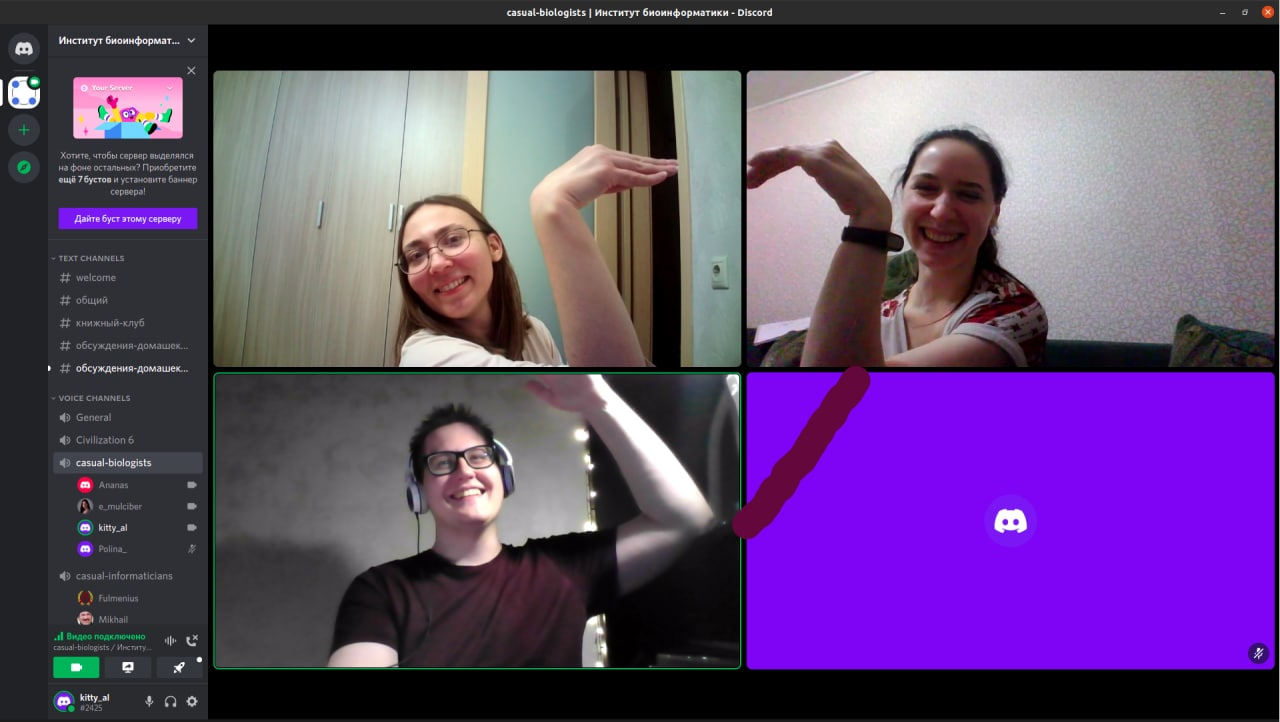

P.S. обсуждали домашки по питону(

P.P.S я слева внизу